# START: Experiment related Graphs

In [1]:
from fastread import Fastread 
from colour import Color
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
from math import cos, asin, sqrt
import copy, math
import ast 
from IPython.core.display import display, HTML
import random

/var/folders/vh/vq38xths5q9c0_2rkctq370w0000gn/T/ipykernel_46106/1243570097.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [24]:
%matplotlib inline

# Define data parameters

In [135]:
city='bristol'
optimum_walking_distances = ['5','10','15','20','30','45']  
experiment_run_for = ['all_on',
                      'all_off',
                      'probability_only',
                      'weather_only',
                      'rating_only',
                      'no_of_tags_only',
                      'popular_time_only',
                      'travel_distance_only',
                      'opennes_only']


# Load data

In [137]:
experiment_data={param:dict() for param in experiment_run_for}
for experiment_parameter in experiment_run_for:
    for owd in optimum_walking_distances:
        experiment_file_name=str(experiment_parameter+'_'+owd)
        ff = Fastread('../evaluation/'+city+'/'+experiment_file_name)
        lines = ff.lines()
        pareto_lines=list()

        for i,line in enumerate(lines): 
            pareto_lines.append(ast.literal_eval(str(line)))
        experiment_data[experiment_parameter][owd]=pareto_lines

# Data Analysis

## Num of POI categorised

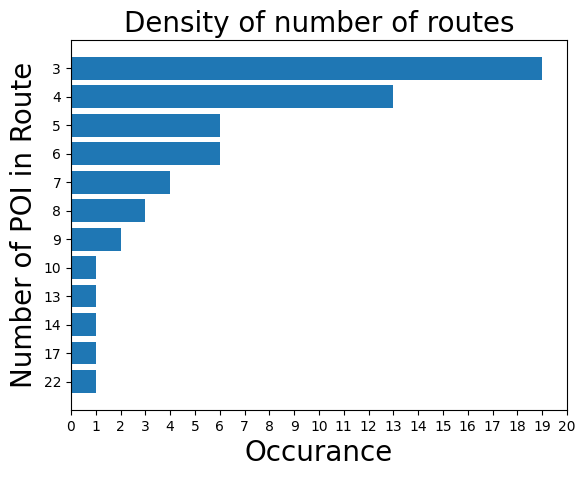

In [8]:
ff = Fastread('../datasets/'+city+'/routes_google_nodes_converted_with_visit_times')
lines = ff.lines()
 
poi_lines=[]
lens=[]
for line in lines:
    p_line=ast.literal_eval(str(line))
    poi_lines.append(p_line)
    lens.append(len(p_line['gmap_node_ids']))
       
labels = list(set(lens))

poi_cats={label:0 for label in labels}

for p_line in poi_lines: 
        poi_cats[len(p_line['gmap_node_ids'])]+=1

fig, ax = plt.subplots() 
y_pos = np.arange(len(labels)) 

ax.barh(y_pos, poi_cats.values(),  align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Occurance',fontsize=20)
ax.set_ylabel('Number of POI in Route',fontsize=20)
ax.set_title('Density of number of routes',fontsize=20)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

ax.set_xticks(np.arange(0, 21, step=1)) #  this is for bristol ds
plt.show()

## POI distance histogram

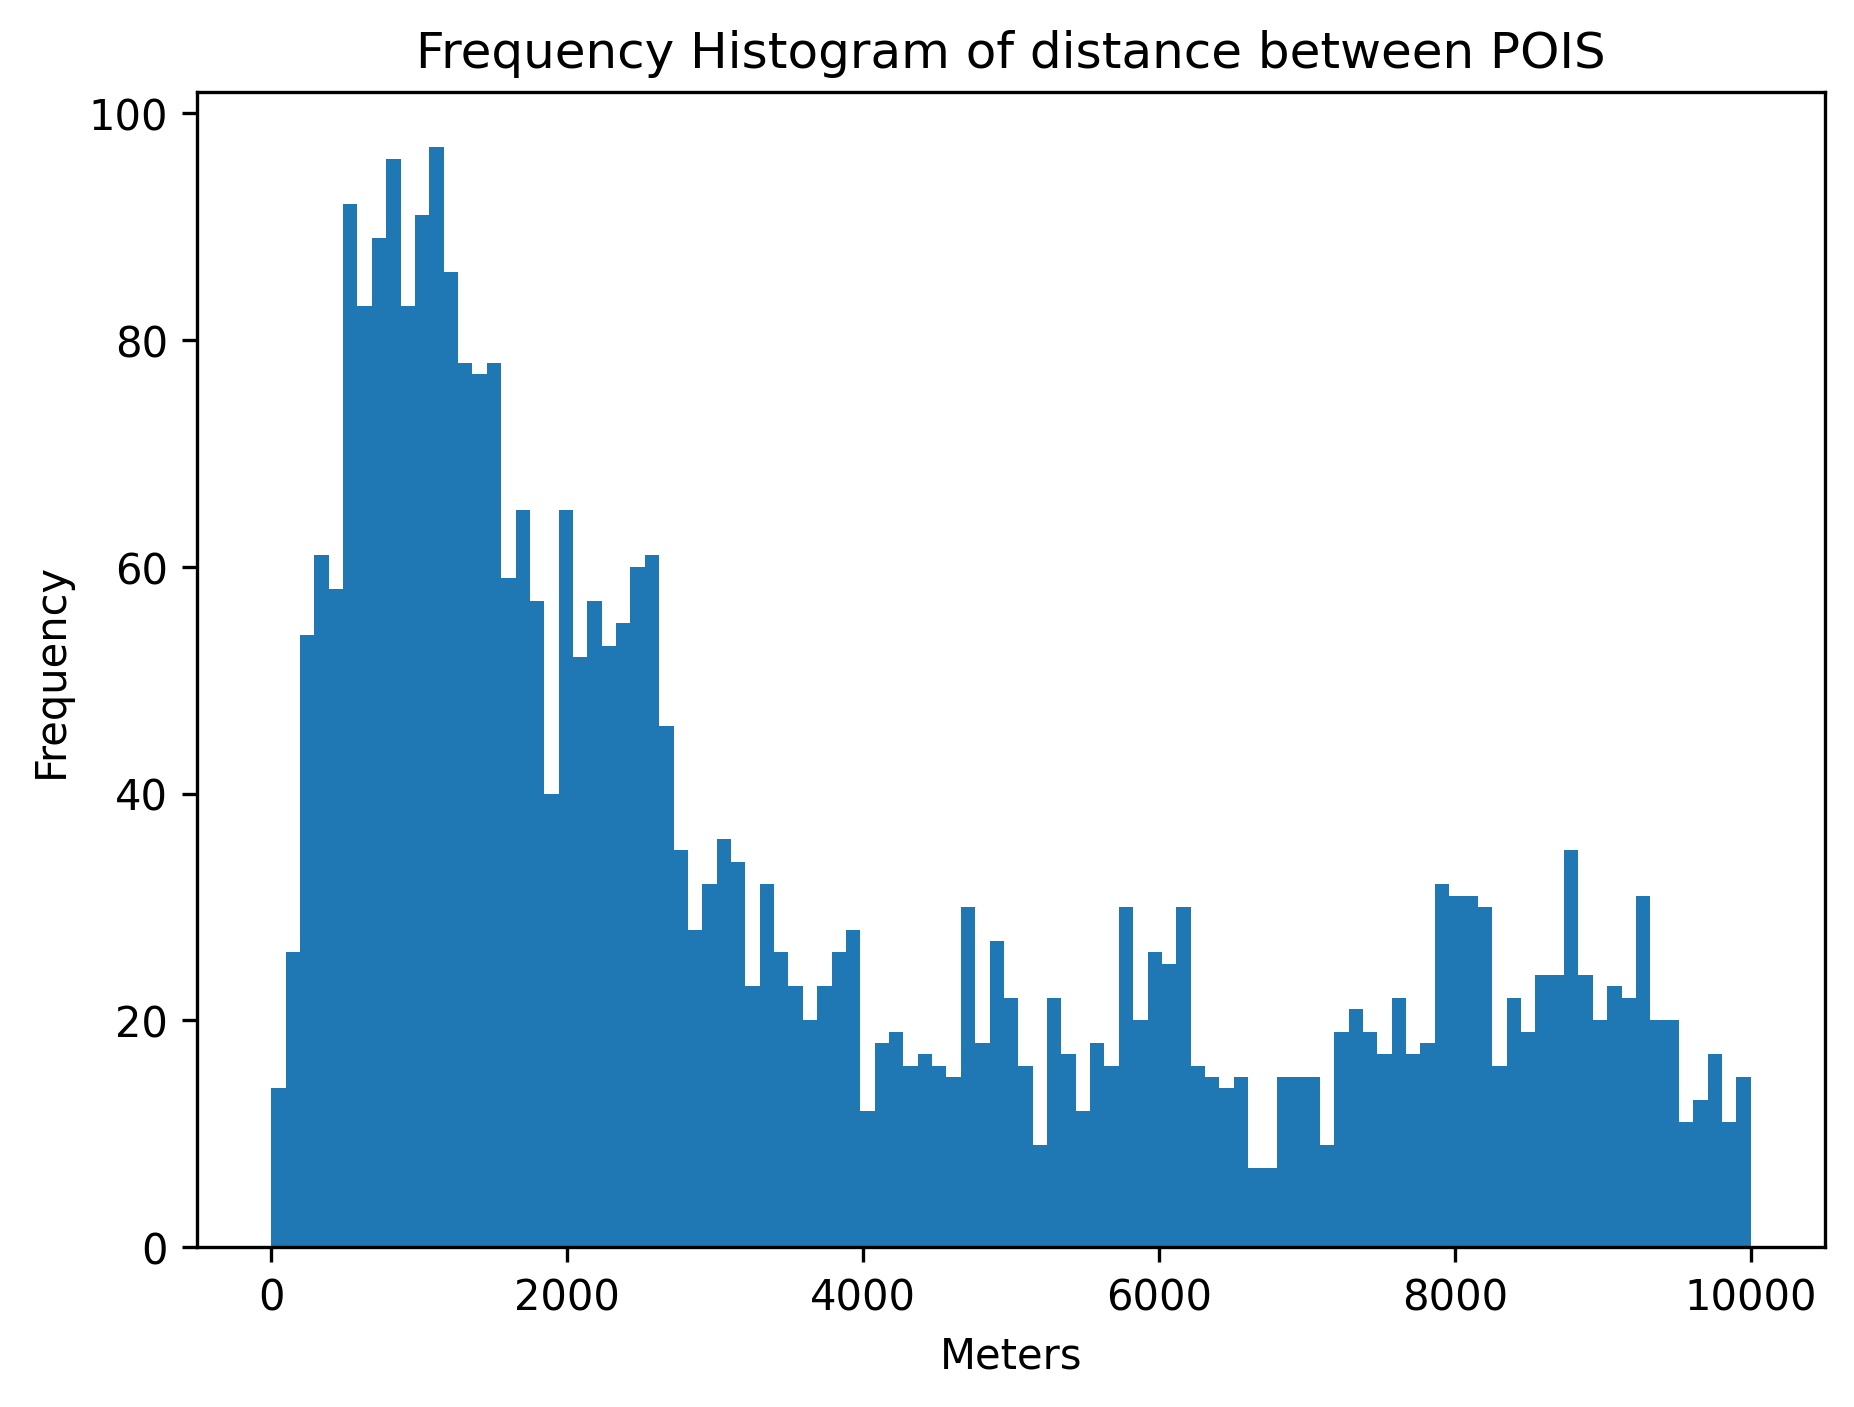

In [92]:
with open('../datasets/'+city+'/distance_matrix') as f:
    dm = f.readlines()
matrix = [ast.literal_eval(item) for item in dm]

distances=[]
processed=[]

groups=set()
for k,v in matrix[0].items():
    processed.append(k)
    for nid,tp in v.items():
        if nid in processed :
            continue
        else:            
            distances.append(tp[1])
            if tp[1]<100:
                groups.add(k)
                groups.add(nid) 

distances.sort()
distances=[dist for dist in distances if dist < 10000 ]

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':300})

# Plot Histogram on x 
plt.hist(distances, bins=103)
plt.gca().set(title='Frequency Histogram of distance between POIS', ylabel='Frequency',xlabel='Meters');

In [204]:
type(distances)

list

# NDCG VS JACCARD pareto graphs for all experiments

In [126]:
# colour function for the graph below
def get_colour(owd):
    if owd =='5':
        return 'orange'
    elif owd == '10':
        return 'blue'
    elif owd == '15':
        return 'green'
    elif owd == '20':
        return 'gold'
    elif owd == '30':
        return 'purple'
    elif owd == '45':
        return 'red'   
    

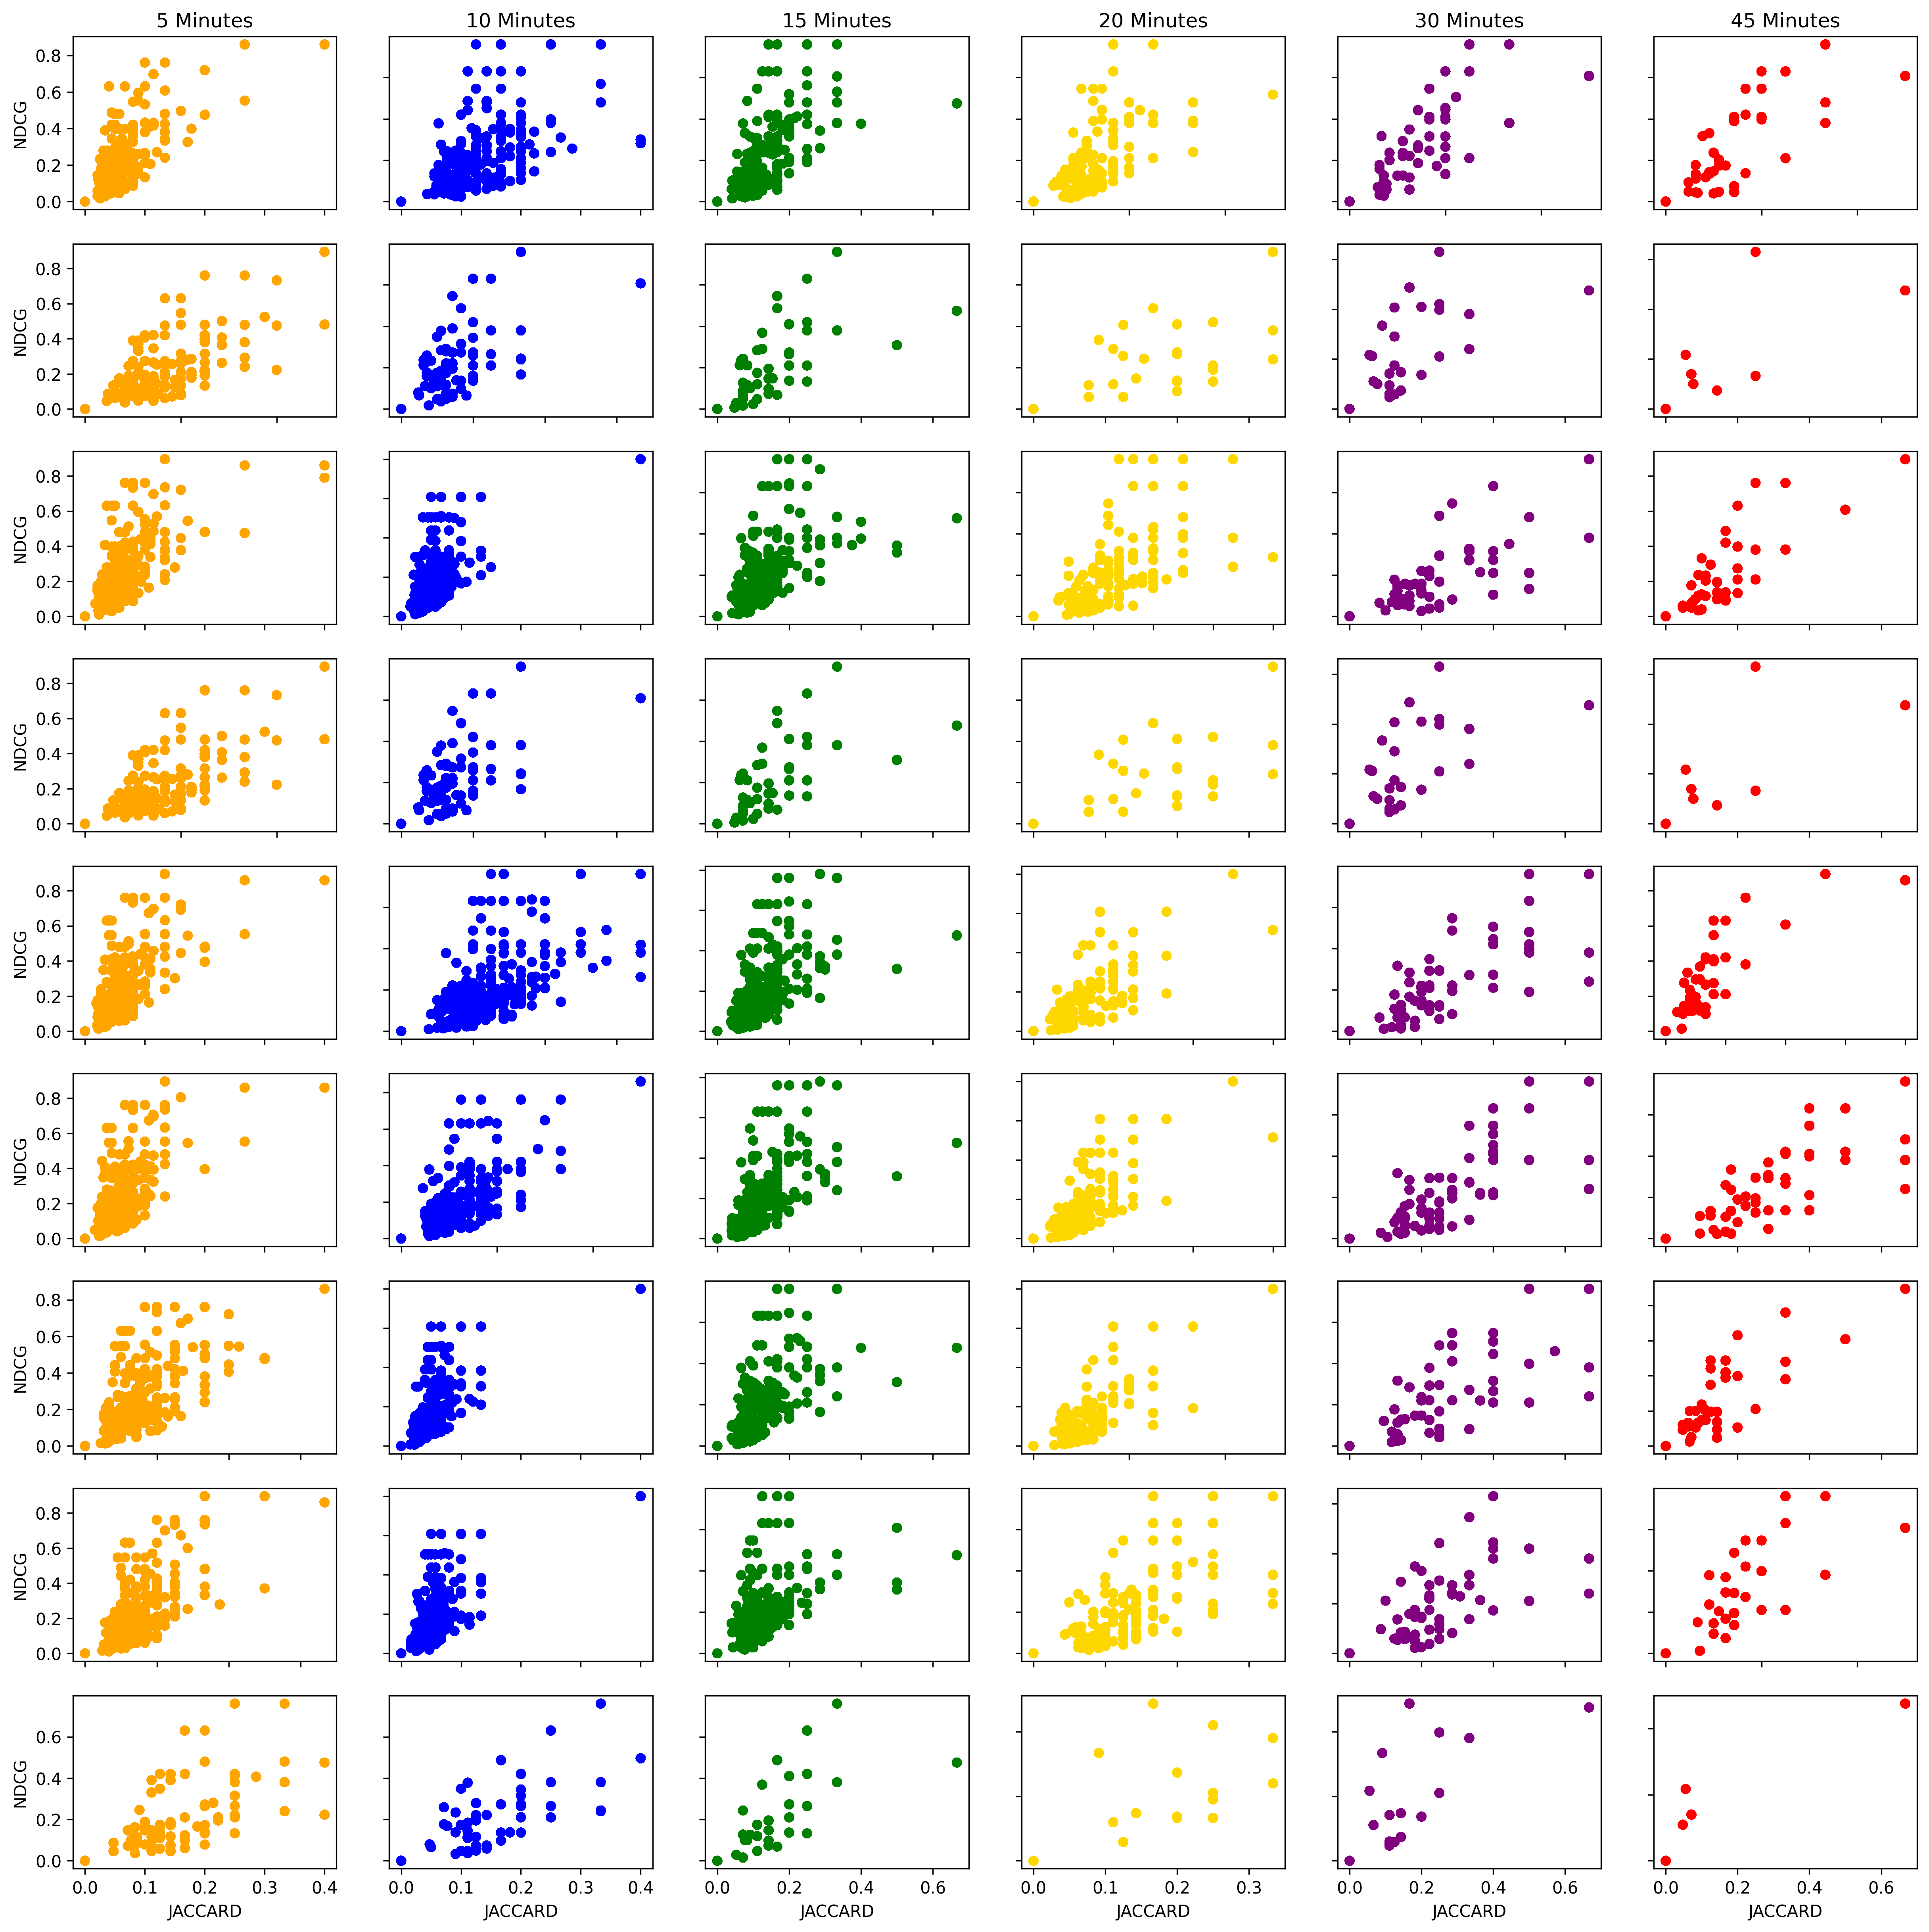

<Figure size 21000x26000 with 0 Axes>

In [185]:
fig, axs = plt.subplots(9, 6)
 
for ex_index,experiment_parameter in enumerate(experiment_run_for):
    for owd_index,owd in enumerate(optimum_walking_distances):
        ndcg_list=[]
        jaccard_list=[]
        for experiment_result in experiment_data[experiment_parameter][owd]:
            ndcg_list.append(experiment_result['best_ndcg'])
            jaccard_list.append(experiment_result['best_jaccard'])
            
            axs[ex_index, owd_index].scatter(jaccard_list, ndcg_list, c=get_colour(owd),edgecolors='none',marker='o')
            if experiment_parameter == 'all_on':
                axs[ex_index, owd_index].set_title(owd+' Minutes')
                
plt.figure(figsize=(105, 130), dpi= 200)
plt.rcParams['figure.figsize'] = [20, 20]  

for ax in axs.flat:
    
    ax.set(xlabel='JACCARD', ylabel='NDCG')
    #ax.set_xticks(np.arange(0, 1.1, step=0.1))  
    #ax.set_yticks(np.arange(0, 1.1, step=0.1))
    # PS: change steeps to 0.2 for Bristol

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Legal and Illegal routes Stat

In [217]:
ff = Fastread('../datasets/'+city+'/routes_google_nodes_converted_with_visit_times')
lines = ff.lines()
pareto_lines=list()

for i,line in enumerate(lines): 
    pareto_lines.append(ast.literal_eval(str(line))) 

In [218]:
owd_dict={owd:0 for owd in optimum_walking_distances}
total=len(pareto_lines)

for i,route_line in enumerate(pareto_lines):
    for minute,val in route_line['is_legal_dict'].items(): 
        owd_dict[str(minute)]+=val
        
for k,v in owd_dict.items():
    owd_dict[k]=math.ceil((v/total)*100)

owd_x=list(owd_dict.keys())
owd_legal=list(owd_dict.values())
owd_illegal=[100-val for val in owd_legal] 

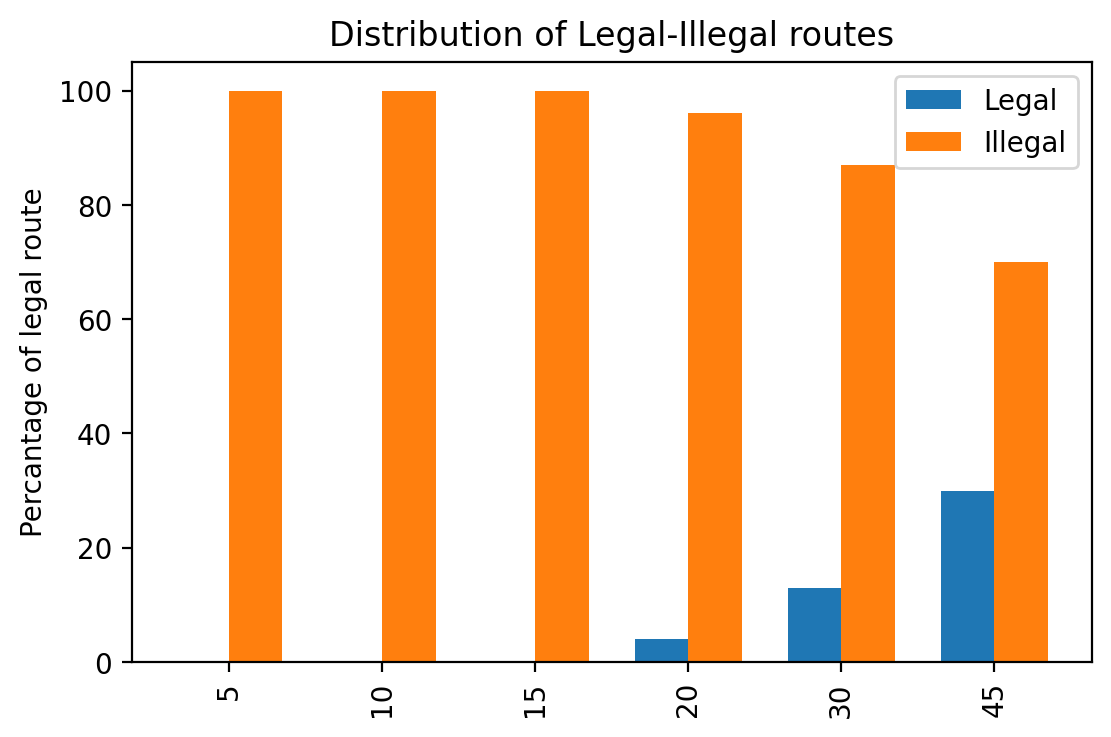

In [219]:
fig = plt.figure(figsize=(6,5), dpi=200)
left, bottom, width, height = 0.1, 0.3, 0.8, 0.6
ax = fig.add_axes([left, bottom, width, height]) 
 
width = 0.35   
ticks = np.arange(len(owd_x))   


ax.bar(ticks, owd_legal, width, label='Legal')
ax.bar(ticks + width, owd_illegal, width, align="center", label='Illegal')

ax.set_ylabel('Percantage of legal route')
ax.set_title('Distribution of Legal-Illegal routes')
ax.set_xticks(ticks + width/2)
plt.xticks(rotation=90)
 
ax.set_xticklabels(owd_x)
 
ax.legend(loc='best')
plt.show()

# Average ndcg and jaccard

In [229]:
experiment_data['opennes_only']

{'5': [{'user_id': '16669082@N05',
   'route_index': 6,
   'file_name': 'opennes_only',
   'total_num_of_tree_nodes': 14,
   'optimum_walking_time': '5',
   'is_legal_dict': {45: 1, 30: 0, 20: 0, 15: 0, 10: 0, 5: 0},
   'user_route_names': ['Nelson Street',
    'The Galleries',
    "The New Room / John Wesley's Chapel"],
   'best_route_names': ['Nelson Street', 'St Nicholas Market', 'Queen Square'],
   'best_ndcg': 0.0,
   'best_jaccard': 0.0,
   'best_route_reward': 0.0,
   'best_route_reward_time': 0.0,
   'best_route_ranking': 0.0,
   'best_route_ranking_time': 0.0,
   'org_route_reward': 0.0,
   'org_route_reward_time': 0.0,
   'org_route_ranking': 1.0,
   'org_route_ranking_time': 1.99816961561928},
  {'user_id': '65548708@N03',
   'route_index': 9,
   'file_name': 'opennes_only',
   'total_num_of_tree_nodes': 28,
   'optimum_walking_time': '5',
   'is_legal_dict': {45: 0, 30: 0, 20: 0, 15: 0, 10: 0, 5: 0},
   'user_route_names': ['Bristol Cathedral',
    'Park Street',
    'Brist

In [226]:
avg_ndcg_minu_dict={owd:{erf:None for erf in experiment_run_for} for owd in  optimum_walking_distances}
avg_jaccard_minu_dict={owd:{erf:None for erf in experiment_run_for} for owd in  optimum_walking_distances}

for erf in experiment_run_for:
    for owd in optimum_walking_distances: 
        avg_ndcg_minu_dict[owd][erf]= np.mean([line['best_ndcg'] for line in experiment_data[erf][owd]])
        avg_jaccard_minu_dict[owd][erf] = np.mean([line['best_jaccard'] for line in experiment_data[erf][owd]])

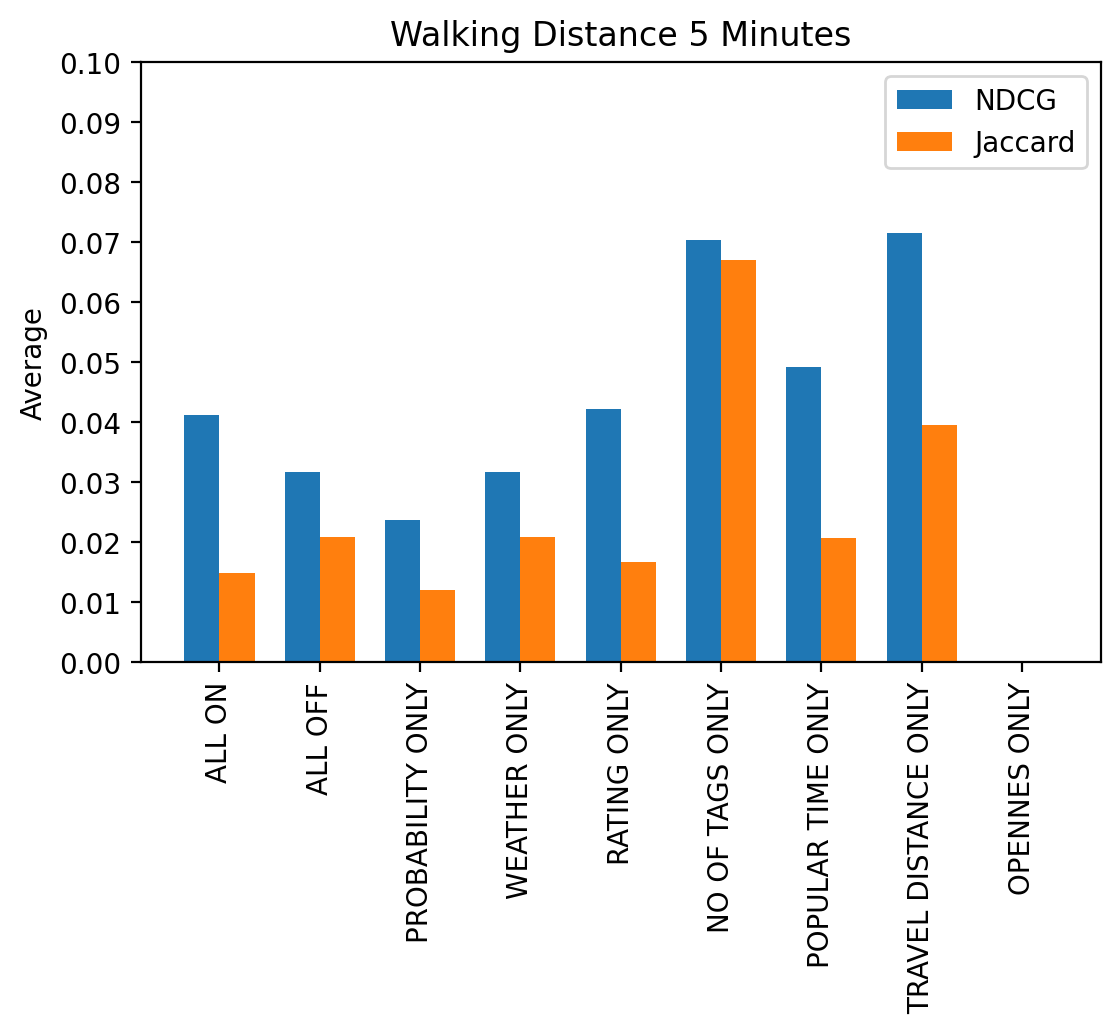

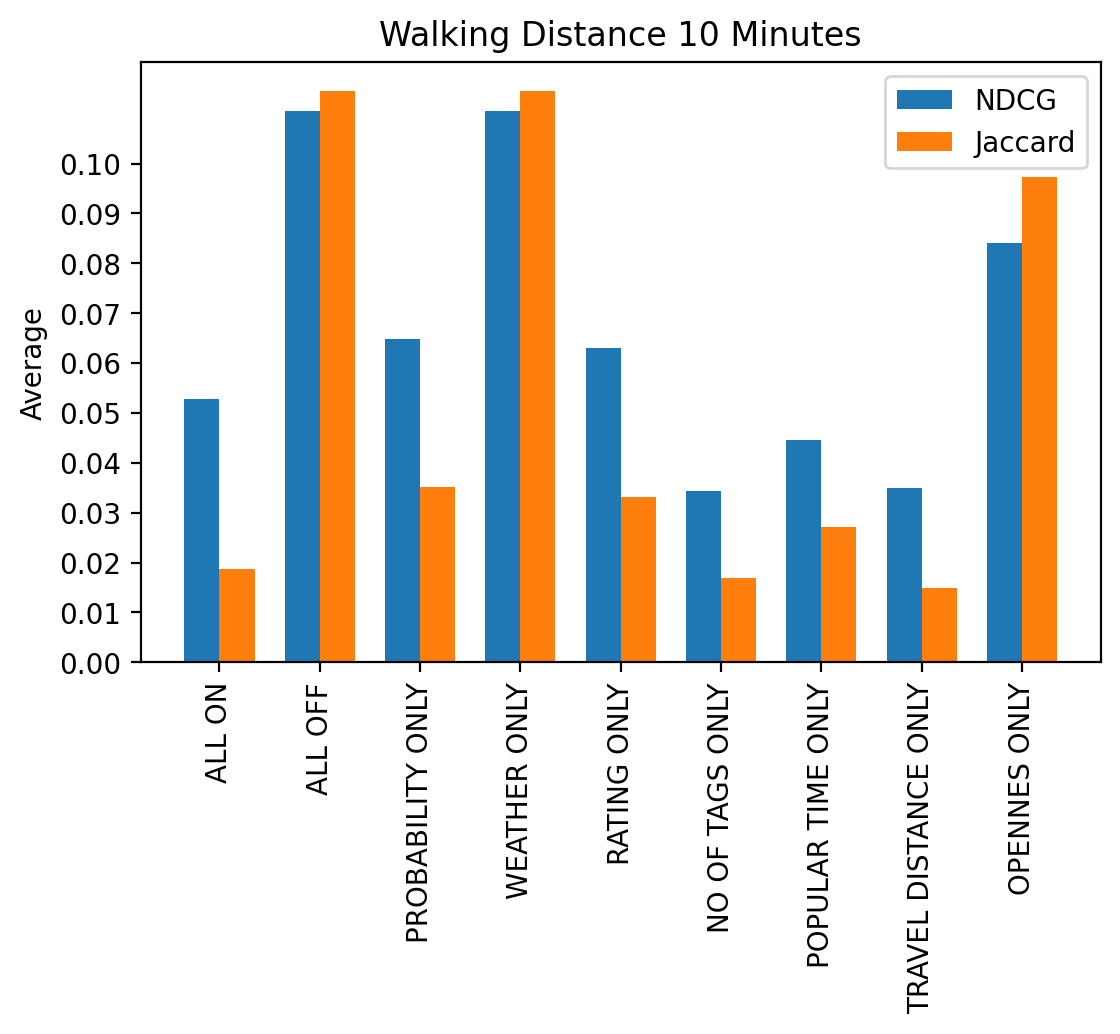

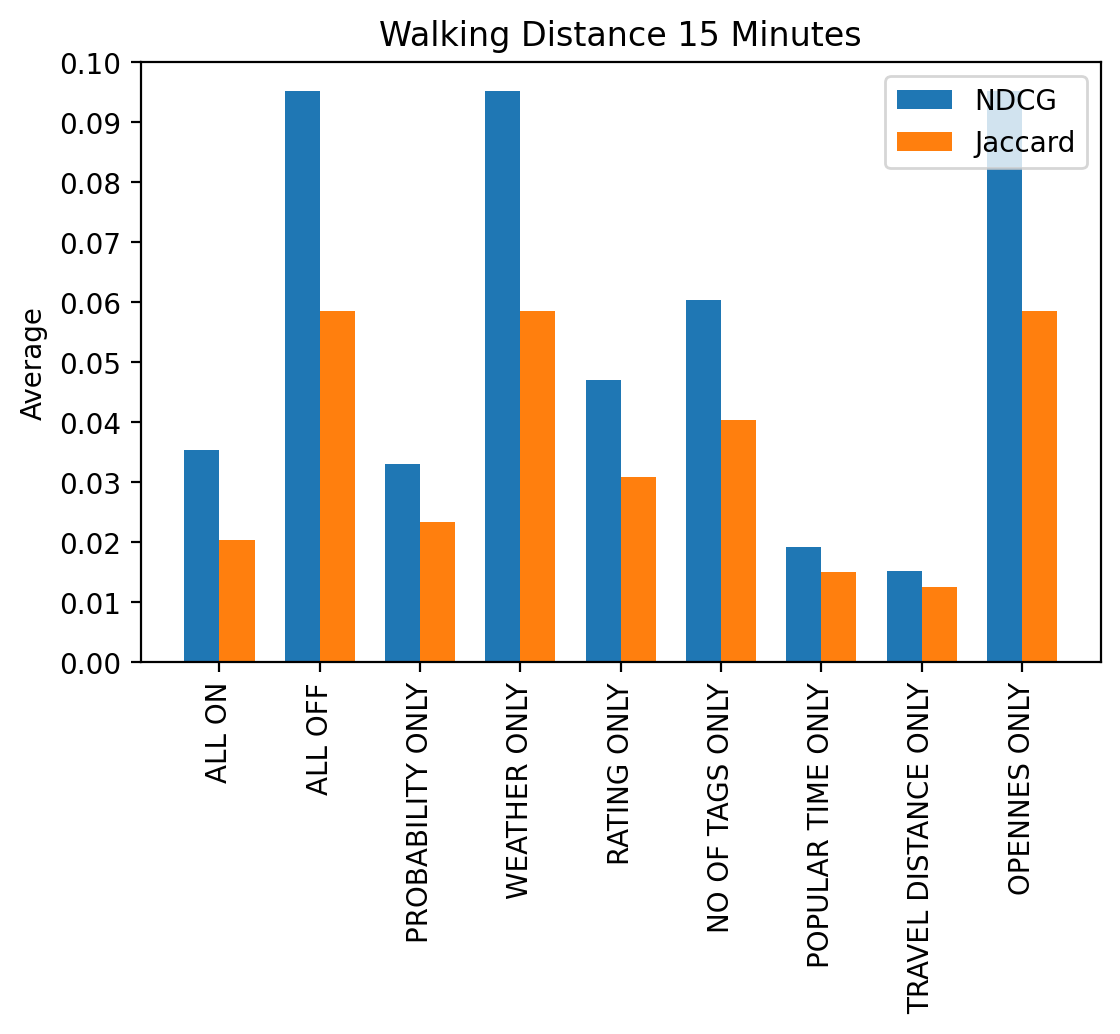

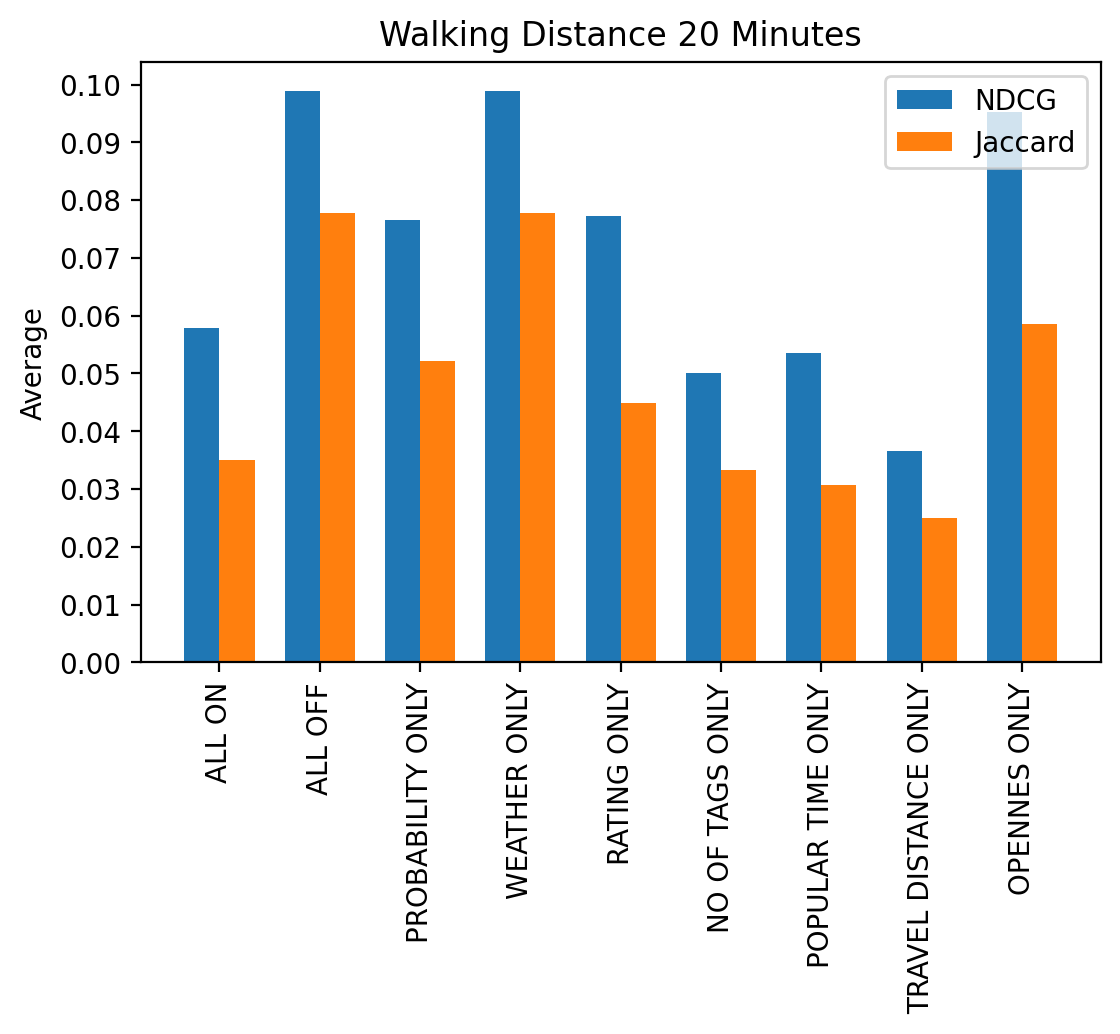

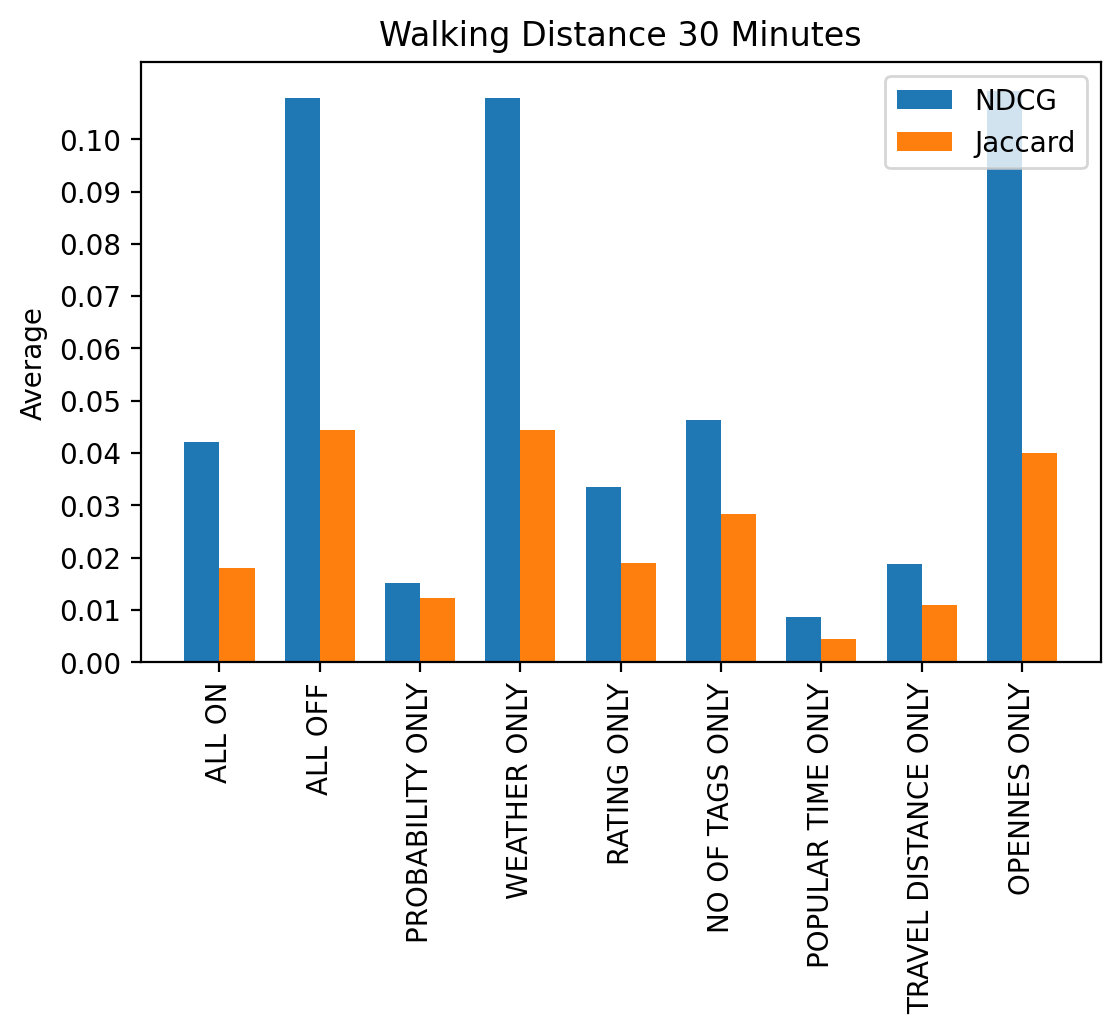

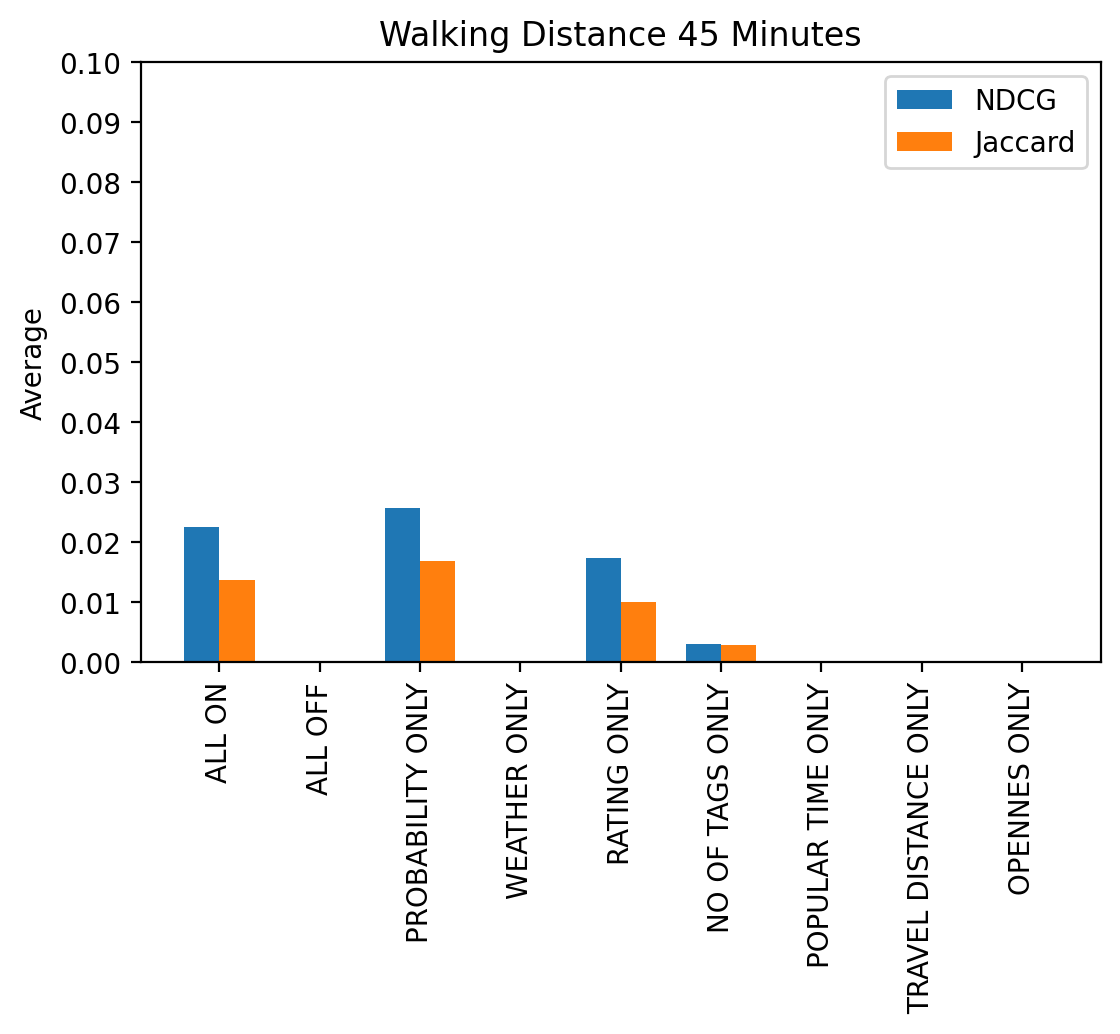

In [227]:
for owd_index,owd in enumerate(optimum_walking_distances): 
    
    fig = plt.figure(figsize=(6,5), dpi=200)
    left, bottom, width, height = 0.1, 0.3, 0.8, 0.6
    ax = fig.add_axes([left, bottom, width, height]) 

    width = 0.35   
    ticks = np.arange(len(avg_ndcg_minu_dict[owd]))    
    ax.bar(ticks, avg_ndcg_minu_dict[owd].values() , width, label='NDCG')
    ax.bar(ticks + width, avg_jaccard_minu_dict[owd].values(), width, align="center", label='Jaccard')

    ax.set_ylabel('Average')
    ax.set_title('Walking Distance '+owd +' Minutes')
    ax.set_xticks(ticks + width/2)
    ax.set_yticks(np.arange(0, 0.11, step=0.01))

    plt.xticks(rotation=90)
    ax.set_xticklabels([fn_p.replace('_', ' ').upper() for fn_p in avg_ndcg_minu_dict[owd].keys()])

    ax.legend(loc='best')
    plt.show()

# Average ndcg and jaccard for legal and illegal  routes

In [164]:
legal_avg_ndcg_minu_dict={owd:{erf:0.0 for erf in experiment_run_for} for owd in  optimum_walking_distances}
illegal_avg_ndcg_minu_dict = {owd:{erf:0.0 for erf in experiment_run_for} for owd in  optimum_walking_distances}

legal_avg_jaccard_minu_dict={owd:{erf:0.0 for erf in experiment_run_for} for owd in  optimum_walking_distances}
illegal_avg_jaccard_minu_dict={owd:{erf:0.0 for erf in experiment_run_for} for owd in  optimum_walking_distances}

for erf in experiment_run_for:
    for owd in optimum_walking_distances: 
        
        legal_ndcg=list()
        legal_jaccard=list()
        illegal_ndcg=list()
        illegal_jaccard=list()
        
        for line in experiment_data[erf][owd]:
            if line['is_legal_dict'][int(owd)]== 1:
                legal_ndcg.append(line['best_ndcg'])
                legal_jaccard.append(line['best_jaccard'])
            else:
                illegal_ndcg.append(line['best_ndcg'])
                illegal_jaccard.append(line['best_jaccard'])
        
        legal_avg_ndcg_minu_dict[owd][erf] = np.mean(legal_ndcg) if len(legal_ndcg) > 0 else 0.0
        legal_avg_jaccard_minu_dict[owd][erf] = np.mean(legal_jaccard) if len(legal_jaccard) > 0 else 0.0
        illegal_avg_ndcg_minu_dict[owd][erf] = np.mean(illegal_ndcg) if len(illegal_ndcg) > 0 else 0.0
        illegal_avg_jaccard_minu_dict[owd][erf] = np.mean(illegal_jaccard)  if len(illegal_jaccard) > 0 else 0.0

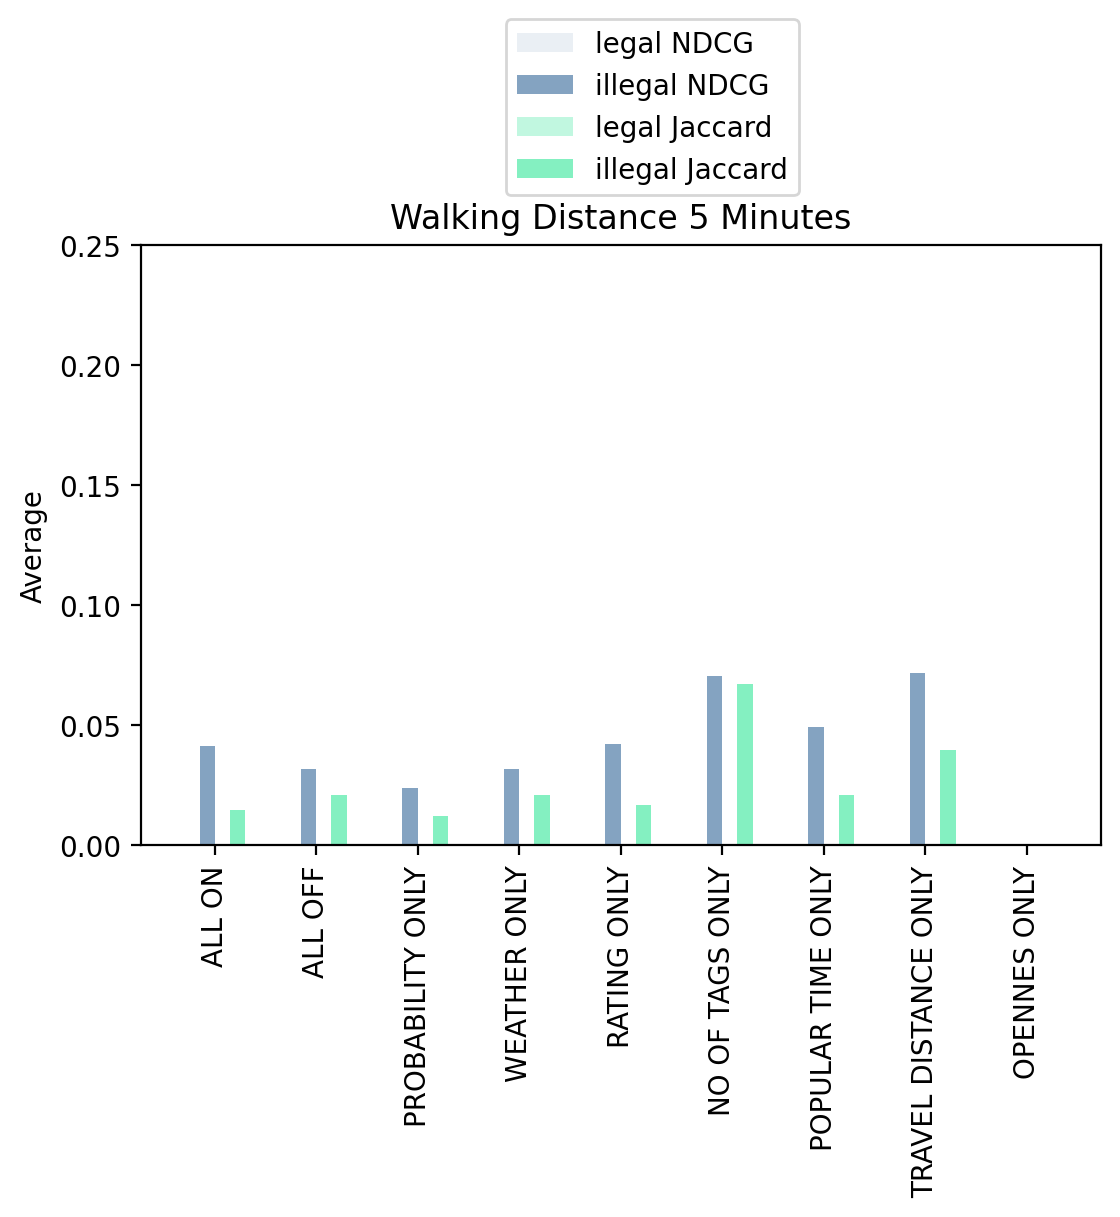

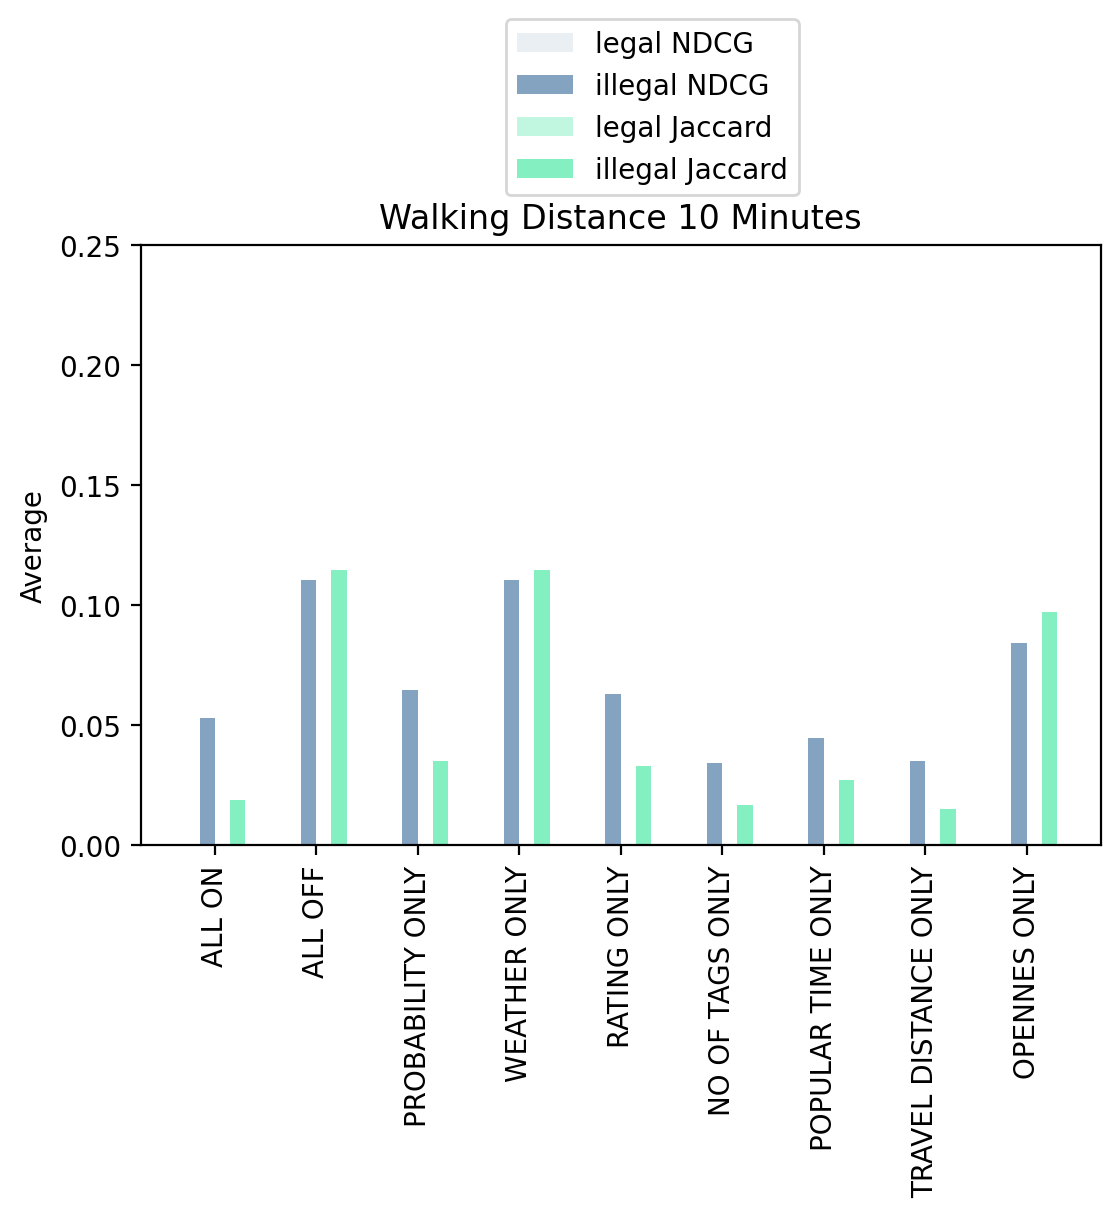

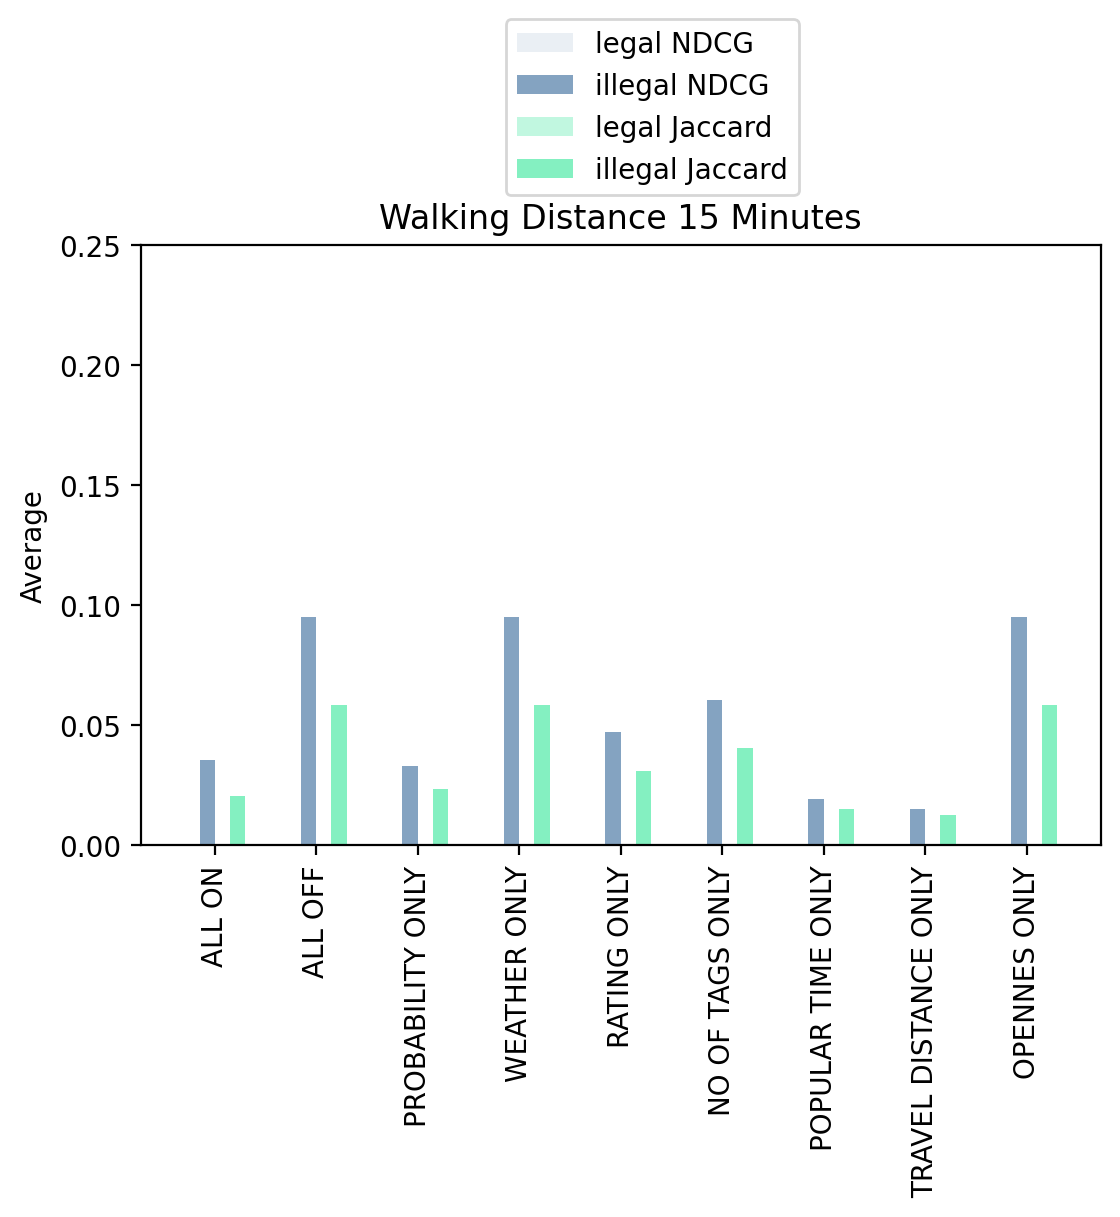

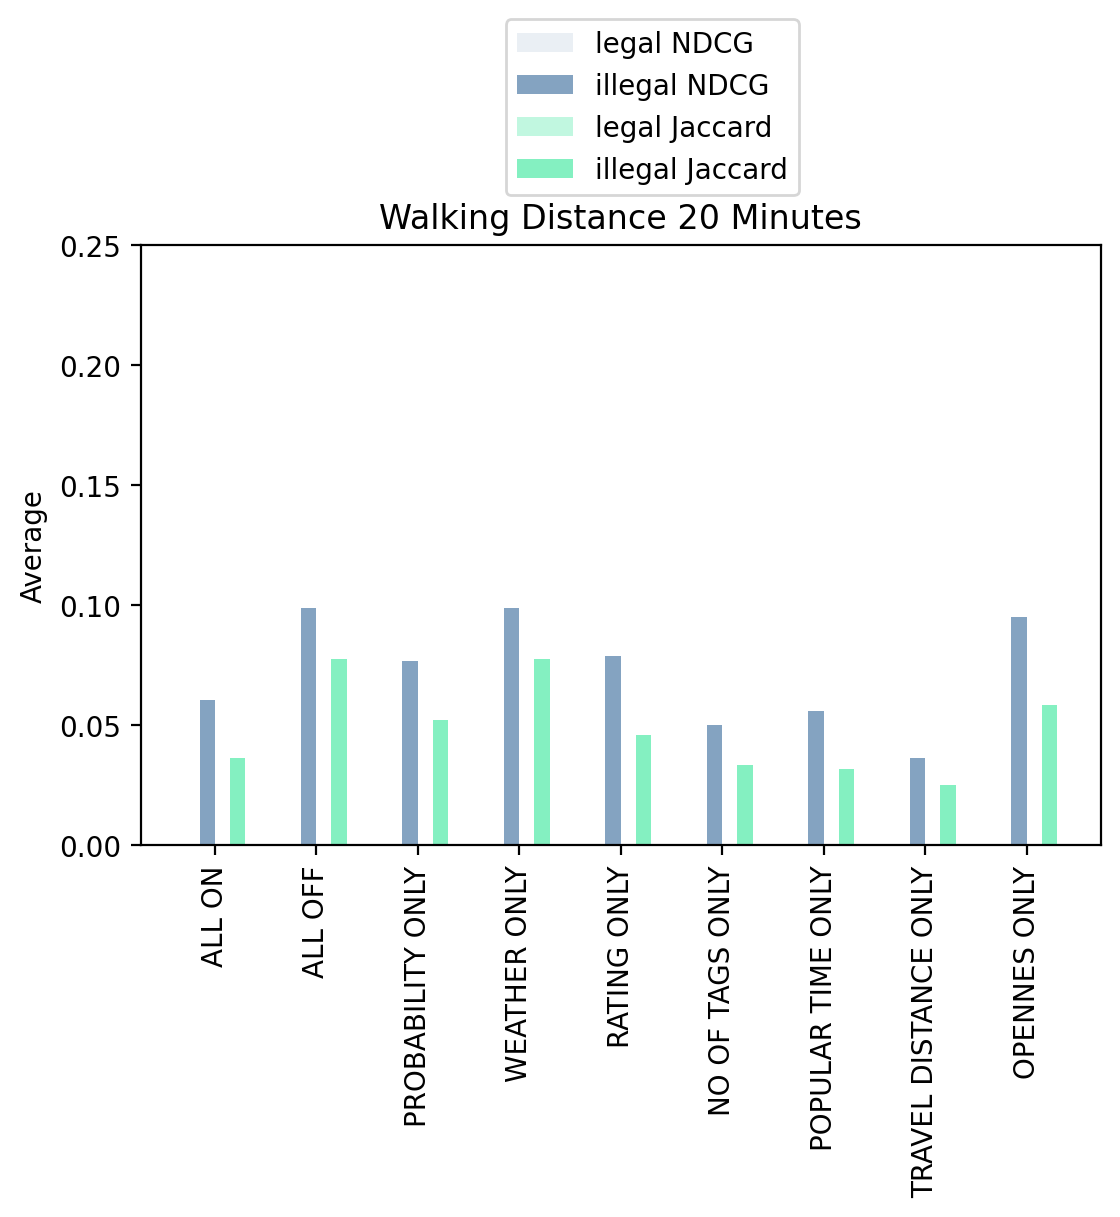

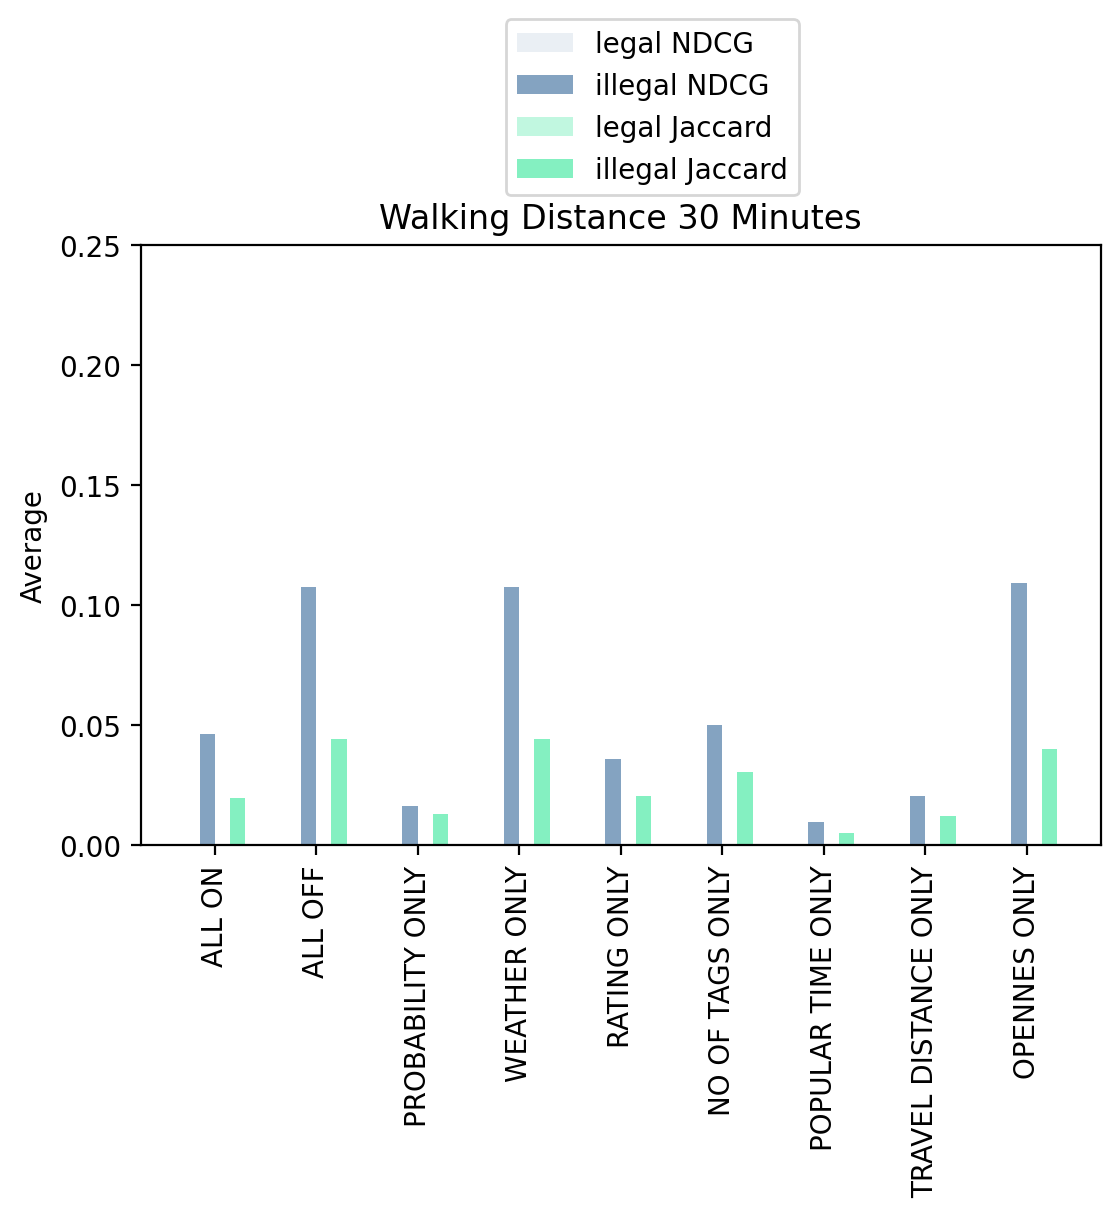

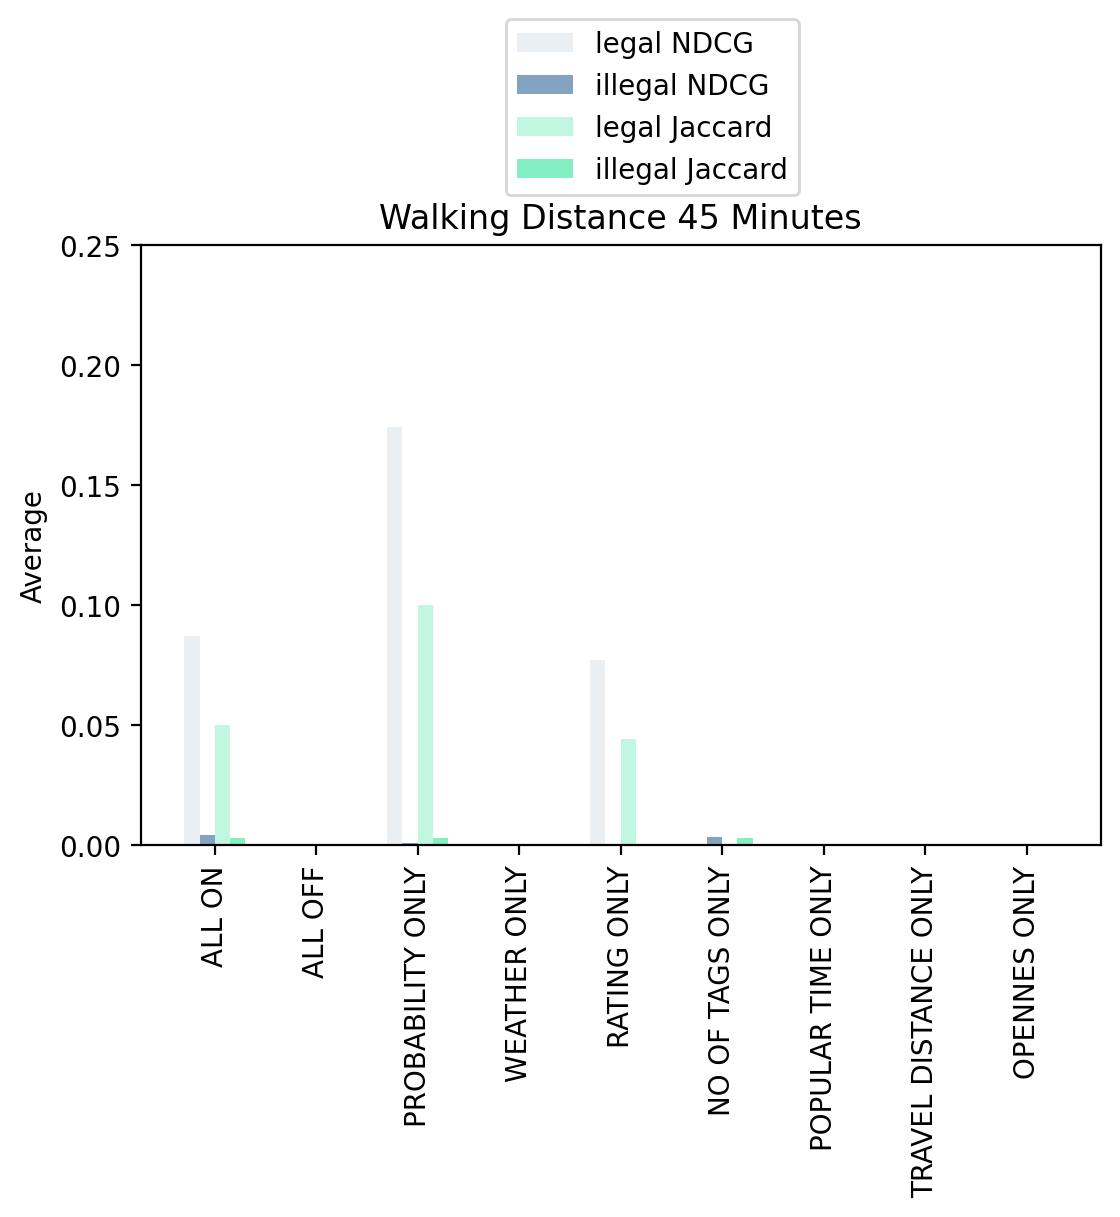

In [172]:
for owd_index,owd in enumerate(optimum_walking_distances): 

    fig = plt.figure(figsize=(6,5), dpi=200)
    left, bottom, width, height = 0.1, 0.3, 0.8, 0.6
    ax = fig.add_axes([left, bottom, width, height]) 

    width = 0.15  
    ticks = np.arange(len(avg_ndcg_minu_dict[owd])) 
    
    ax.bar(ticks - width, legal_avg_ndcg_minu_dict[owd].values(), width, label='legal NDCG', color=(0.2, 0.4, 0.6, 0.1))

    ax.bar(ticks, illegal_avg_ndcg_minu_dict[owd].values(), width, label='illegal NDCG', color=(0.2, 0.4, 0.6, 0.6))


    ax.bar(ticks+ width , legal_avg_jaccard_minu_dict[owd].values(), width, align="center", label='legal Jaccard', color=(0.2, 0.9, 0.6, 0.3))

    ax.bar(ticks + 2*width, illegal_avg_jaccard_minu_dict[owd].values(), width, align="center", label='illegal Jaccard', color=(0.2, 0.9, 0.6, 0.6))

    ax.set_ylabel('Average') 
    ax.set_xticks(ticks + width/2)
    ax.set_ylabel('Average')
    ax.set_title('Walking Distance '+owd +' Minutes')
    plt.xticks(rotation=90)
    ax.set_xticklabels([fn_p.replace('_', ' ').upper() for fn_p in avg_ndcg_minu_dict[owd].keys()])
    ax.set_yticks(np.arange(0, 0.3, step=0.05))

    ax.legend(loc='upper right', bbox_to_anchor=(0.7, 1.4))
    plt.show()

# Reward comparison for Original and Generated Routes

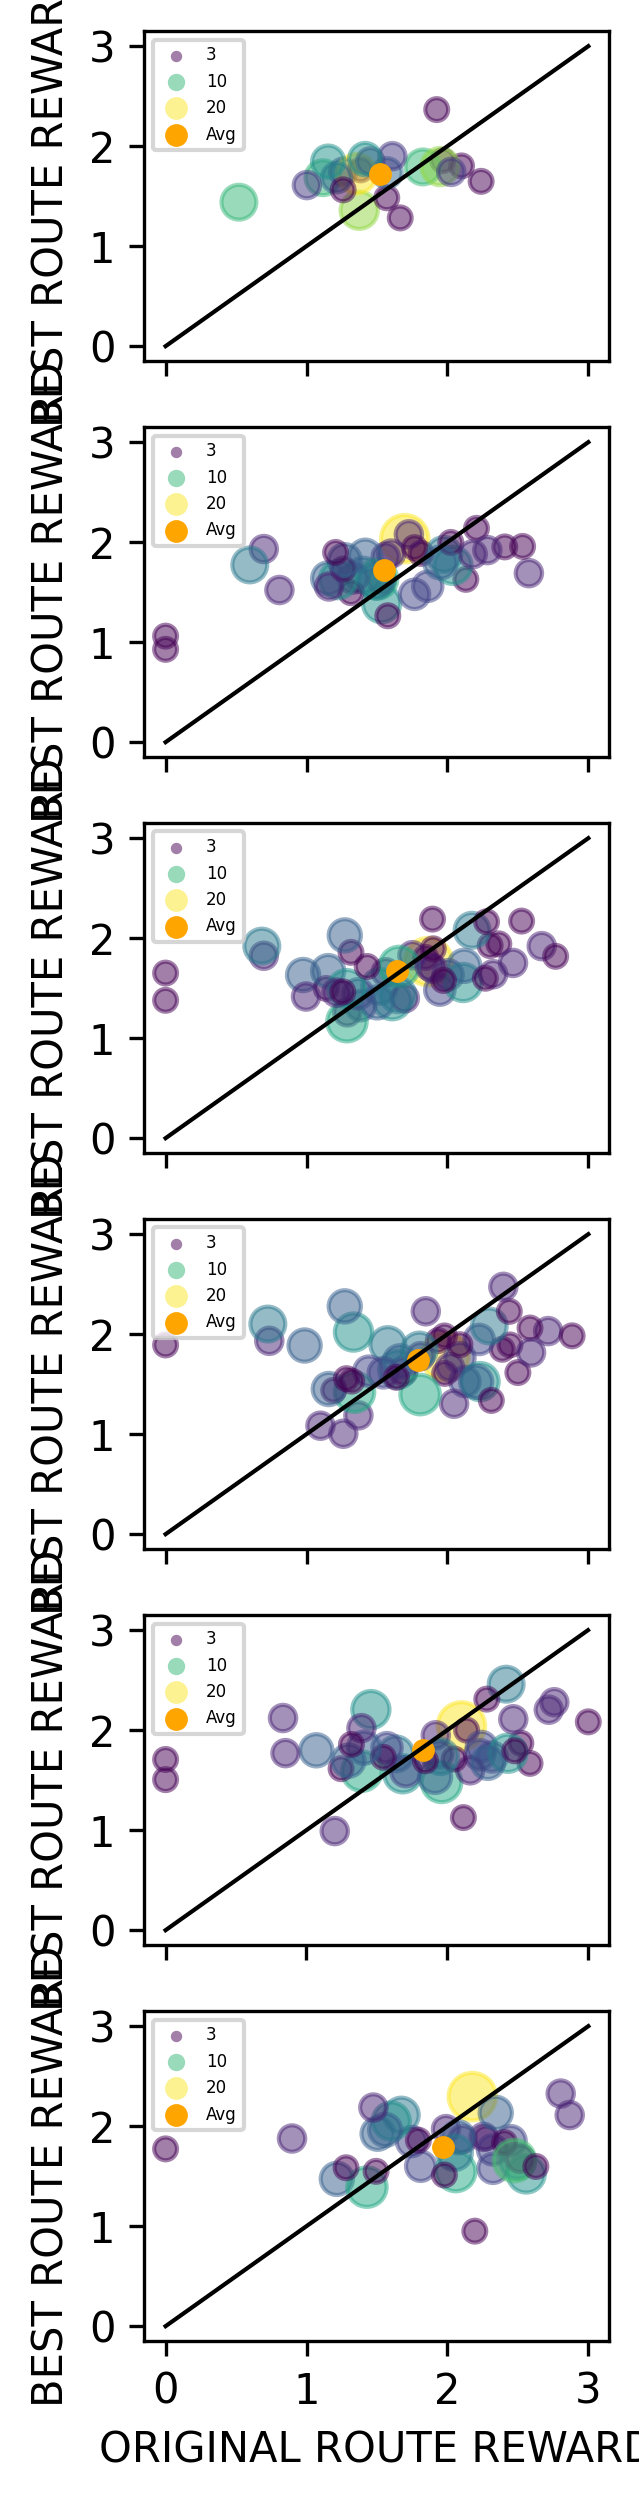

<Figure size 2000x20000 with 0 Axes>

In [141]:
fig, axs = plt.subplots(6, 1)
 
erf='all_on'
for owd_index,owd in enumerate(optimum_walking_distances):
    org_route_reward_list=[]
    best_route_reward_list=[]
    lengths=[]
    for ind, experiment_result_line in enumerate(experiment_data[erf][owd]):
        org_route_reward_list.append(experiment_result_line['org_route_reward'])
        best_route_reward_list.append(experiment_result_line['best_route_reward'])
        lengths.append(len(experiment_result_line['user_route_names'])*10)

    x_mean=sum(org_route_reward_list)/len(org_route_reward_list)
    y_mean=sum(best_route_reward_list)/len(best_route_reward_list)

    axs[owd_index].scatter(x=org_route_reward_list,y=best_route_reward_list, alpha=0.5,s=lengths, c=lengths)

    axs[owd_index].plot([0, 3], [0, 3], color = 'black', linewidth = 1)
    axs[owd_index].scatter(x_mean,y_mean, color = 'orange',s=20)
    
    if 1==1:
        gll = plt.scatter([],[], s=3, marker='o', color='#a17fa9')
        gl = plt.scatter([],[], s=10, marker='o', color='#99dabb')
        ga = plt.scatter([],[], s=20, marker='o', color='#fdf291')
        avg = plt.scatter([],[], s=20, marker='o', color='orange')


        axs[owd_index].legend((gll,gl,ga,avg),
               ('3', '10', '20','Avg'), # min , middle , max num of nodes
               scatterpoints=1,
               loc='upper left',
               ncol=1,
               fontsize=4) 
        


    
plt.figure(figsize=(10, 100), dpi= 200)
plt.rcParams['figure.figsize'] = [2, 10]  

for ax in axs.flat:
    
    ax.set(xlabel='ORIGINAL ROUTE REWARD', ylabel='BEST ROUTE REWARD')
    ax.set_xticks(np.arange(0, 3.1, step=1))  
    ax.set_yticks(np.arange(0, 3.1, step=1)) 

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()